# **Training RL policies**

This notebook is used for training RL_policies. At the moment this is still exploratory, but later this should change. 

For training the RL policies we use sb3, as minigrid recommends. 

### **Register  and loading an env**

First we need to register an env  to gymnasium (once). Note that here we use already the ProbalisticEnvWrapper class that we made. For more info about how we load the envs see /envs/README.md

In [13]:
from envs.registry import register_env

env_name = "FourRoomsEnv"
register_env(f"./envs/configs/goal_state/{env_name}.yaml")

[Gym] Registered environment: FourRoomsEnv-v0


'FourRoomsEnv-v0'

Once we have it registered, we need to load it from gymnasium again. Additionally, the observatsion returned by the step type is a dictionary. However, we use the PPO algorithm and it does expect a different format from the observation. We use the ImgObsWrapper, which lets the obs to be only an image, such that it can be porcessed by an CNN. 

Additionally we use a ReseedWrapper in order to ensure that we have the same seed after reset is called. We need this as if we want to use the DeltaShield during training, we will need to build a storm model before hand. For that we need to ensure that the environment we build the model for is the same as for during training. Hence, the same seed all the time.  

In [14]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, ReseedWrapper

env = gym.make(f"{env_name}-v0")
env = ImgObsWrapper(env)
env = ReseedWrapper(env, seeds=[42])  # Use a single fixed seed
env.unwrapped.max_steps = 500 # Increase max steps to allow for longer episodes, which is necessary for some envs


### **Set up a shield**

If we want to use a shield during training, it needs to be passed as an attribute to the ProbabilisticEnvWrapper. As we applied an ImgObsWrapper to the env, we need to use unwrapped for access to the ProbabilisticEnvWrapper.

Below we will use a DeltaShield as example which we can then use during training. We won't go into detail on how the delta shield works, but the shield will basically see the lava states as safety-critical and hence, block actions that are likely to end up in a lava cell. 

For the DeltaShield, one needs to have a model defined first, for which we can use the convert_to_probabilistic_storm(). 

In [15]:
# from shield import DeltaShield

# env.reset()

# env.add_lava()
# model, _ = env.unwrapped.convert_to_probabilistic_storm()
# shield = DeltaShield(model, "Pmin=? [F \"lava\"]", delta=0.5)

# env.unwrapped.set_shield(shield)



We can add a logger that will log the activities of the shield for more information.

In [16]:
# # Setup logging for shielding
# from logging_config import setup_logging
# import logging

# setup_logging(log_level=logging.INFO, console_level=logging.ERROR)

### **Train the model**

Although the observations of minigrid are now images, the CNN archtiecture of SB3 does not driectly support the Minigrid space. Hence we define our own feature Extractor. For ore info, check out the minigrid documentation: 
[minigrid training documentation](https://minigrid.farama.org/content/training/)

In [17]:
import torch 
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

As said before, we use the PPO algorithm for training the policy. 

In [18]:
from stable_baselines3 import PPO


policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

#Logging for PPO
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure

log_dir = "./logs/ppo_minigrid/"
PPO_logger = configure(log_dir, ["stdout", "csv"])


model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1,)
model.set_logger(PPO_logger)
model.learn(total_timesteps=4e5,)

Logging to ./logs/ppo_minigrid/
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 750      |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 574      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 750         |
|    ep_rew_mean          | 0           |
| time/                   |             |
|    fps                  | 457         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013632316 |
|    clip_fraction        | 0.0

Note that in case the policy is not performing well yet (cf. episode reward mean in the output of the previous cell), you could opt to just do it again. 

Finally, let's save the model

In [19]:
model.save(f"policies/PPO_{env_name}-v0")

### **Evaluation**

Note that you could load the model again with ``model = PPO.load("filename")``

For evaluation we use the evaluate_policy method from sb3.


In [20]:
from stable_baselines3.common.evaluation import evaluate_policy


evaluate_policy(model, env, n_eval_episodes=1000, render=False)

/home/noah/Noah_tmp/thesis/Minigrid2Storm/.venv/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(np.float64(0.0), np.float64(0.0))

### **Plotting**

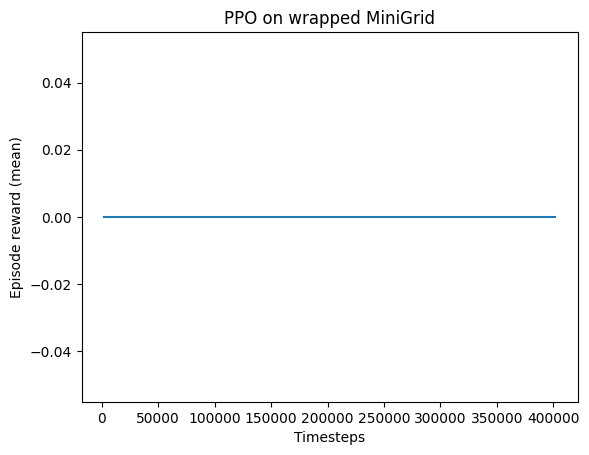

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("logs/ppo_minigrid/progress.csv")

plt.plot(df["time/total_timesteps"], df["rollout/ep_rew_mean"])
plt.xlabel("Timesteps")
plt.ylabel("Episode reward (mean)")
plt.title("PPO on wrapped MiniGrid")
plt.show()